In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from itertools import combinations
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from collections import defaultdict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [2]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1287, 71)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,spikes_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,spikes_rms,mean_rms,max_rms,var_rms,std_rms,spikes_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,spikes_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,spikes_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,spikes_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,spikes_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,s1_an_1,m,anger,0,1443,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,750,0.402497,0.097249,0.311847,83,0.129479,0.340202,0.007750,0.088035,58,1814.026368,812.639867,4084.492417,437557.880517,661.481580,69,1834.495092,1104.902824,2673.005407,154644.510964,393.248663,71,3811.157227,904.394531,6707.592773,2.016124e+06,1419.902686,344,22.718679,7.062807,51.588313,82.005473,9.055687,65,0.093647,0.026855,0.269531,0.001995,0.044666,13.766113,-171.056549,115.938042,-28.566433,21.314878,-26.507704,10.144446,-22.394417,-6.446075,-20.058737,-9.614692,-15.731797,-8.805966,-2.915169,-12.226694,-5.387331,-4.913488,-9.523164,-1.791623,-3.507744,0.083974
1,s1_an_2,m,anger,0,1297,4.795432,3.266728e-10,1598.459473,1602.659546,40.033230,578,0.369817,0.094729,0.307780,64,0.122001,0.275363,0.007222,0.084985,46,1813.929245,1077.773997,4802.078139,517671.206155,719.493715,46,1772.517500,1209.119846,2615.316302,160594.827485,400.742845,48,3602.609923,1711.889648,7288.989258,2.051509e+06,1432.308845,304,22.243432,5.936659,48.160193,77.321635,8.793272,42,0.095251,0.034668,0.402832,0.004444,0.066661,11.715820,-187.978119,114.721764,-41.258282,22.174334,-12.715221,11.881121,-22.636301,-9.284859,-23.113136,-7.031469,-15.980973,-11.601790,-5.727098,-6.378960,-7.155036,-7.385511,-8.306025,4.346861,-6.595266,-2.742662
1,s1_an_5,m,anger,0,909,6.344573,4.247520e-10,4932.327637,6391.681152,79.947990,536,0.312011,0.098784,0.314300,61,0.140534,0.410695,0.008144,0.090243,50,1577.596083,731.779647,3118.561755,152720.583570,390.794810,47,1621.112545,998.916801,2391.307207,100143.189503,316.454088,62,3149.887457,775.195312,5910.864258,1.215127e+06,1102.328088,304,23.661057,6.420219,50.013285,71.860833,8.477077,52,0.072095,0.033203,0.153809,0.000541,0.023251,8.867676,-180.083939,119.054886,-42.182270,26.999893,-6.590928,8.636041,-17.951387,-20.642817,-24.792250,-4.610571,-18.438587,-11.906024,-3.913879,-11.295942,-3.214928,-6.571509,-0.506520,1.930403,-6.855784,-2.346526
1,s1_an_4,m,anger,0,898,7.300478,3.510179e-10,3062.532715,4610.922363,67.903770,417,0.272837,0.095383,0.308841,58,0.155781,0.308454,0.007771,0.088151,41,1578.663080,989.554541,3072.898800,113822.283518,337.375582,37,1679.770568,1277.610555,2577.918929,89344.835302,298.906064,39,3222.159447,1539.624023,6180.029297,9.498801e+05,974.617910,238,23.566948,8.367288,49.570257,78.338294,8.850892,44,0.068912,0.036621,0.134277,0.000354,0.018807,7.304688,-166.445877,122.271973,-42.199047,19.365204,-21.122906,8.933196,-21.792807,-10.018277,-22.990005,-9.038509,-19.050367,-9.762544,0.404813,-14.561901,-6.730536,-4.809193,-5.546733,2.948940,-6.117626,-3.003350
1,s1_an_3,m,anger,0,1392,3.334237,3.032449e-10,689.850098,542.464478,23.290867,603,0.402758,0.097614,0.312432,57,0.093039,0.258287,0.007551,0.086896,61,1699.189320,1154.867212,2519.734104,118628.430190,344.424782,51,1764.541591,1131.241853,2699.423772,195473.567039,442.123927,57,3558.226103,1604.223633,5770.898438,1.733753e+06,1316.720683,301,21.846660,6.884981,48.784060,66.028699,8.125805,58,0.089708,0.041016,0.129395,0.000406,0.020160,10.675293,-241.878052,123.269180,-36.750164,15.108225,-17.863935,12.1

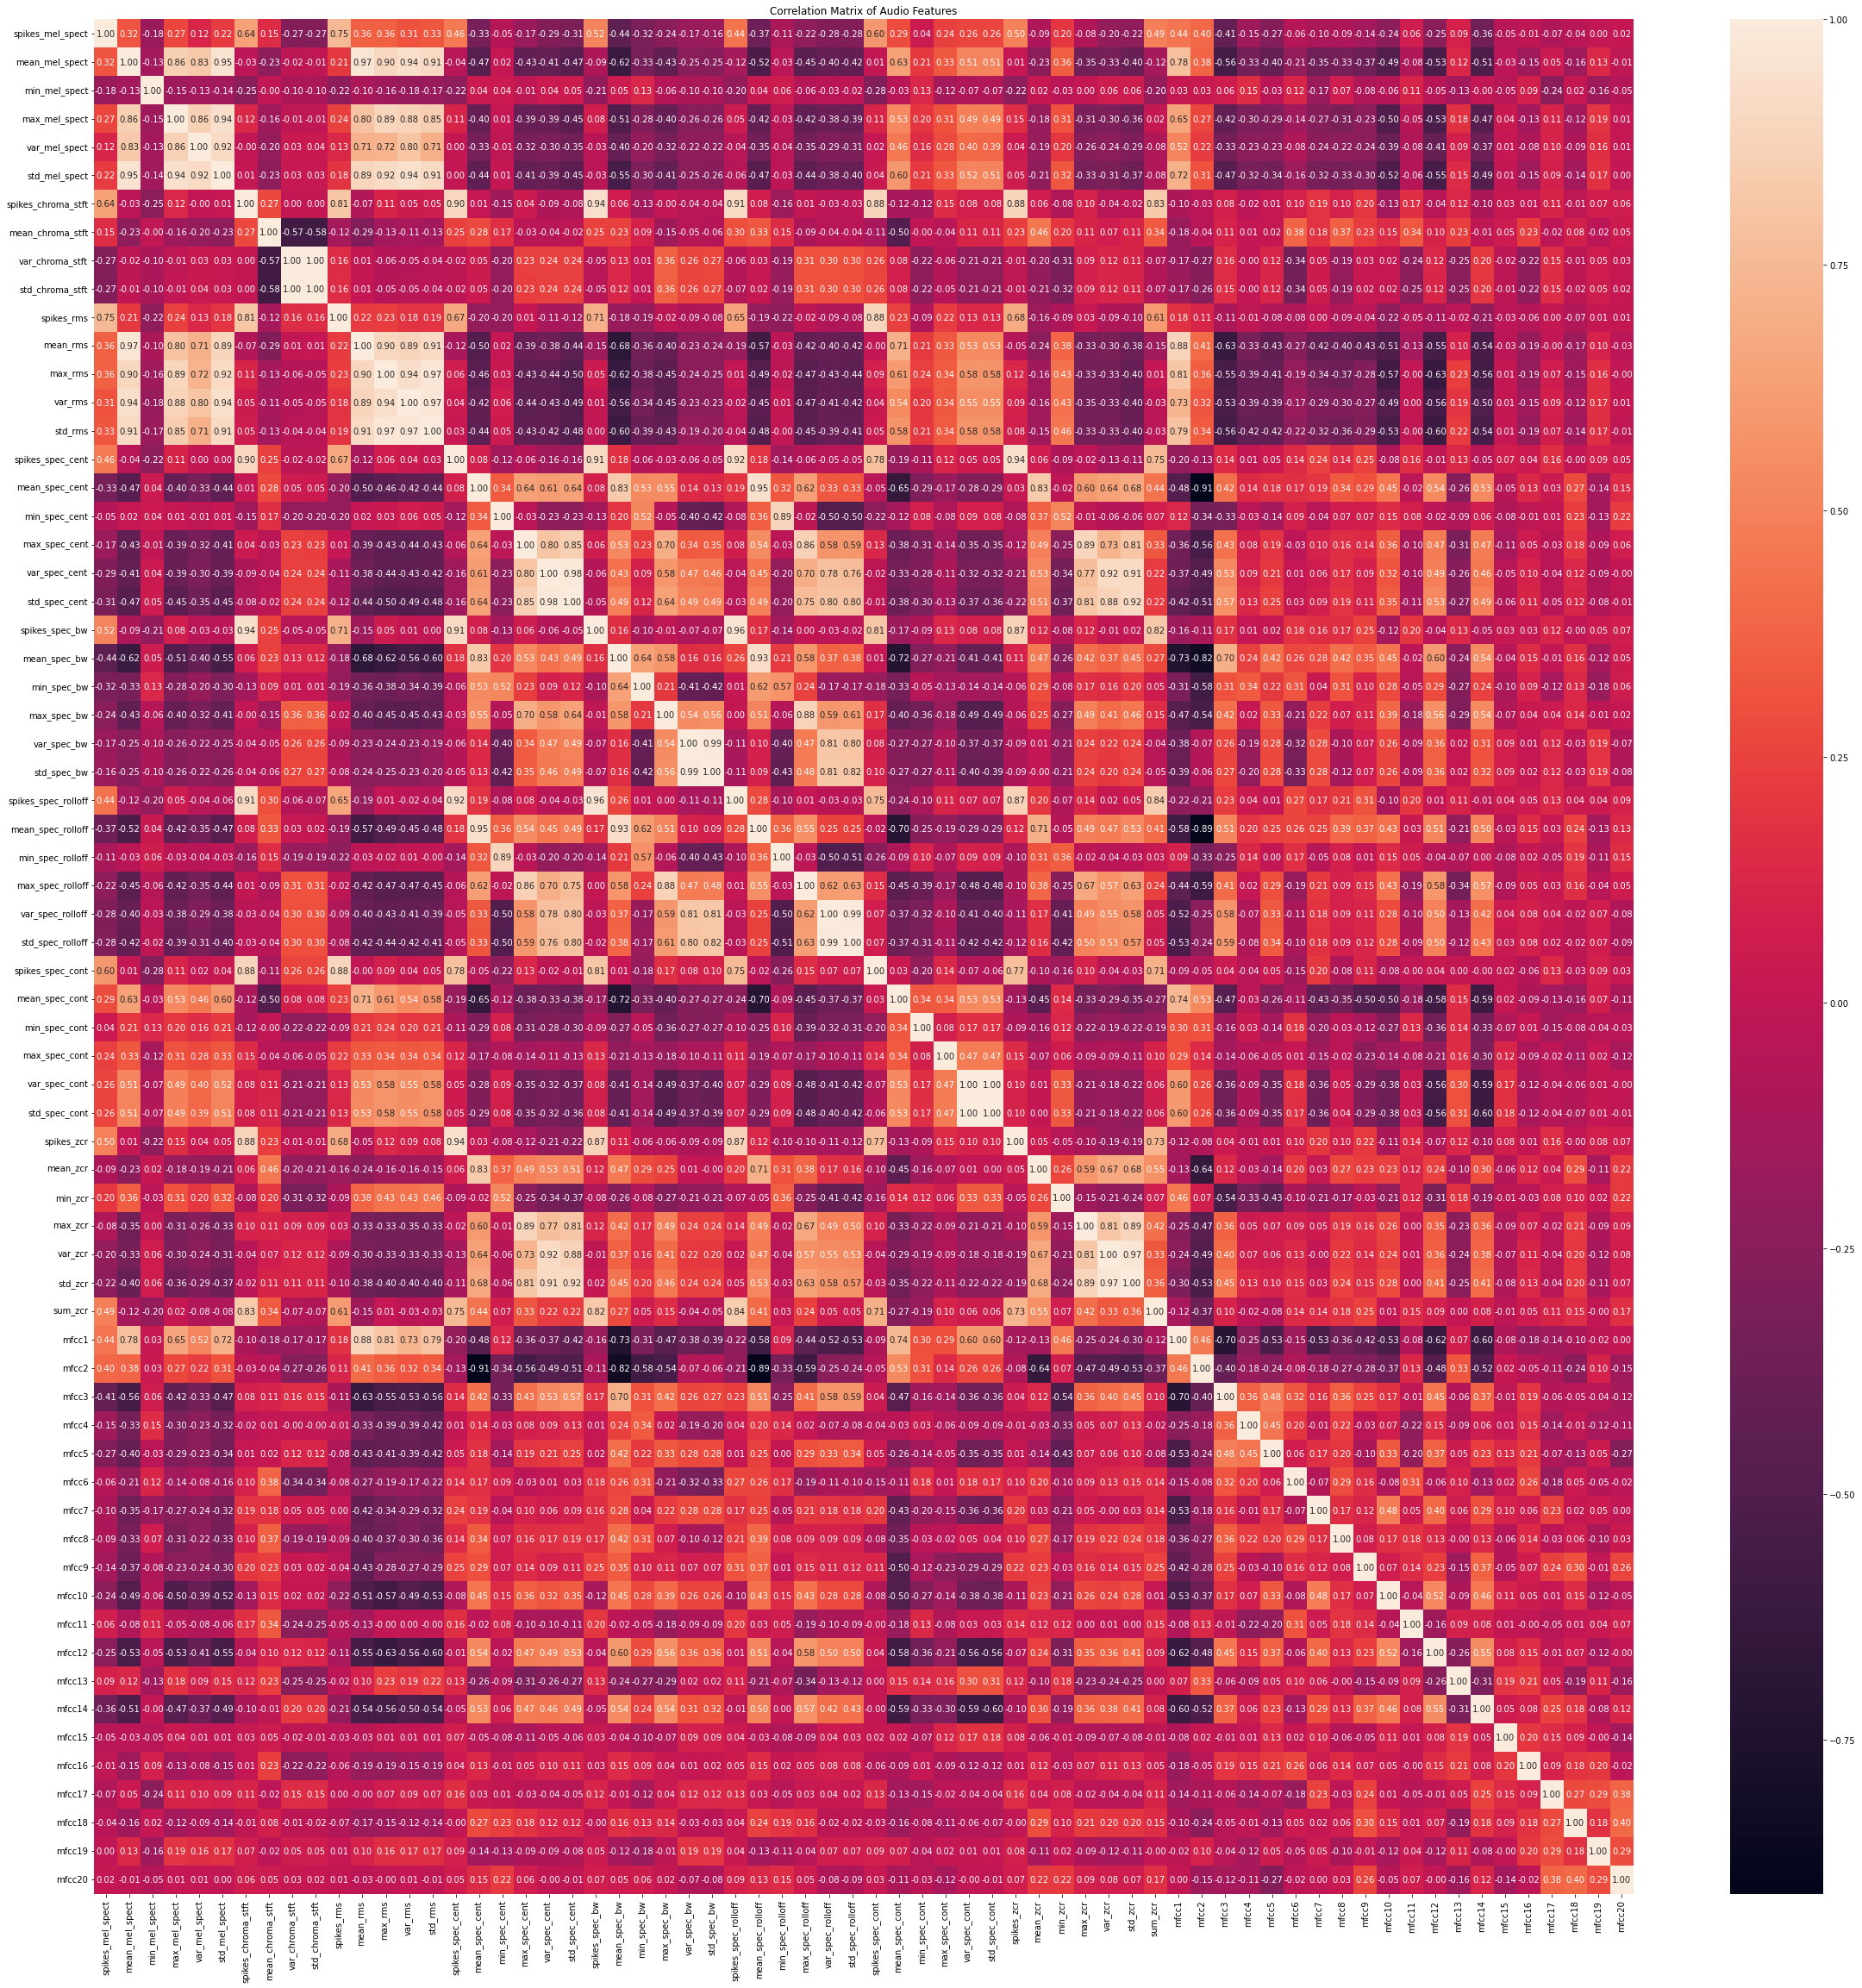

In [4]:
plt.figure(figsize=(40,40))
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.show()

In [27]:
def hight_corr_feat_elimination(df_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > 0.7\
            and ((pair[0][1], pair[0][0]), pair[1]) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), pair[1]))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > 0.7 and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            highest_corr_feat = f1 if mean_corr_f1 > mean_corr_f2 \
                else f2
            eliminated_feats.add(highest_corr_feat)

    return eliminated_feats

In [28]:
eliminated_feats = hight_corr_feat_elimination(df_corr)
print(len(eliminated_feats))
print(eliminated_feats)

30
{'std_spec_bw', 'spikes_spec_cent', 'std_spec_cent', 'mean_spec_bw', 'var_spec_cent', 'spikes_chroma_stft', 'var_rms', 'mean_spec_cent', 'max_mel_spect', 'var_spec_cont', 'var_spec_rolloff', 'max_spec_cent', 'max_rms', 'var_zcr', 'min_spec_cent', 'var_chroma_stft', 'spikes_spec_rolloff', 'mean_rms', 'mean_spec_rolloff', 'spikes_zcr', 'std_rms', 'std_zcr', 'spikes_spec_bw', 'mfcc1', 'sum_zcr', 'spikes_rms', 'std_spec_rolloff', 'std_mel_spect', 'max_spec_rolloff', 'mean_mel_spect'}


In [34]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
print(f"Number of features after high correlation elimination: {len(df.columns)-4}")

Number of features after high correlation elimination: 36


In [35]:
def feature_test(data, features, n_features):
    feature_results = defaultdict(dict)
    labels = data["Emotion_Id"].values
    df_train = data.copy()
    df_train.drop("Emotion_Id", inplace=True, axis=1)

    # generate all groups of n_features to be dropped
    for drop_features in combinations(features, n_features):
        X_train = df_train.copy()

        feats = ()
        # drop each feature on the combination
        for i, feature in enumerate(drop_features):
            feats += (feature,)

            X_train.drop(feature, inplace=True, axis=1)

            if feats in feature_results[i+1]:
                continue

            clf = tree.DecisionTreeClassifier(random_state=1)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            
            feature_results[i+1][feats] = mean_score

    # sort and return
    return feature_results

In [ ]:
data = df.iloc[:,3:]
features = df.columns.values[4:]
# see decision tree and random forest accuracies

In [36]:
data = df.iloc[:,3:]
features = df.columns.values[4:]
feature_results = feature_test(data, features, 2)

KeyboardInterrupt: 

In [8]:
data_results = {}
for n_feat, results in feature_results.items():
    dict_res = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)[:20])
    data_results.update(dict_res)
data_results = pd.DataFrame().from_dict(data_results, orient="index", columns=["Score"])
data_results

,Score
"(mfcc1,)",0.323271
"(mean_mel_spect,)",0.320152
"(max_spec_cont,)",0.320128
"(min_mel_spect,)",0.316243
"(mfcc6,)",0.315492
"(max_spec_bw,)",0.315477
"(min_zcr,)",0.314705
"(mfcc3,)",0.311601
"(min_spec_cont,)",0.311583
"(mean_spec_cont,)",0.311568


In [6]:
y = data["Emotion_Id"].values
no_label_data = data.copy()
no_label_data.drop("Emotion_Id", inplace=True, axis=1)
X = no_label_data

clf = tree.DecisionTreeClassifier(random_state=1)
sfs1 = sfs(clf, k_features=65, forward=False, cv=5, n_jobs=7)
sfs1 = sfs1.fit(X, y)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)
sfs1 = sfs(clf, k_features=64, forward=False, cv=5, n_jobs=7)
sfs1 = sfs1.fit(X, y)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.3232708955448979
['mfcc1']
0.3341296413597563
['min_mel_spect', 'mfcc1']
